In [1]:
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
import torch
import umap
from ogb.nodeproppred import DglNodePropPredDataset
from sklearn.decomposition import PCA

Using backend: pytorch


In [3]:
dataset = DglNodePropPredDataset('ogbn-arxiv', root='../../data/dataset_dgl')
graph = dataset[0][0]

In [4]:
output_emb_file = '../../models/graphsage_link_pred/full_graphsage_linkpred_30_h.npy'

In [5]:
embeddings = np.load(output_emb_file)
embeddings.shape

(169343, 50)

## L2 Distance

In [6]:
index = faiss.IndexFlatL2(embeddings.shape[1])

In [7]:
index.train(embeddings)
index.add(embeddings)

In [8]:
index

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7f2ac9c73de0> >

In [9]:
index.ntotal

169343

### Check if the closest embedding is a neighbor

In [10]:
distances, indices = index.search(embeddings, 2)

In [11]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(44249)

In [12]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [13]:
max_k = 100
distances, indices = index.search(embeddings, max_k + 1)

In [14]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [15]:
has_neighbor

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

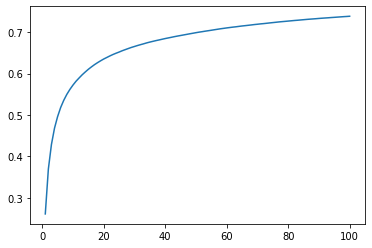

In [16]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [17]:
percentages

tensor([0.2613, 0.3697, 0.4289, 0.4683, 0.4960, 0.5181, 0.5353, 0.5497, 0.5617,
        0.5721, 0.5814, 0.5893, 0.5970, 0.6038, 0.6102, 0.6160, 0.6214, 0.6262,
        0.6308, 0.6350, 0.6387, 0.6424, 0.6459, 0.6490, 0.6518, 0.6549, 0.6577,
        0.6604, 0.6630, 0.6653, 0.6676, 0.6697, 0.6718, 0.6740, 0.6759, 0.6777,
        0.6794, 0.6810, 0.6827, 0.6844, 0.6859, 0.6874, 0.6890, 0.6904, 0.6917,
        0.6931, 0.6945, 0.6959, 0.6972, 0.6986, 0.6998, 0.7010, 0.7022, 0.7033,
        0.7044, 0.7056, 0.7068, 0.7080, 0.7090, 0.7100, 0.7110, 0.7120, 0.7128,
        0.7138, 0.7147, 0.7155, 0.7164, 0.7172, 0.7182, 0.7189, 0.7198, 0.7204,
        0.7213, 0.7221, 0.7229, 0.7237, 0.7245, 0.7252, 0.7259, 0.7266, 0.7272,
        0.7279, 0.7285, 0.7292, 0.7299, 0.7306, 0.7312, 0.7317, 0.7323, 0.7329,
        0.7335, 0.7340, 0.7345, 0.7351, 0.7356, 0.7361, 0.7367, 0.7372, 0.7377,
        0.7382])

In [18]:
percentages.max()

tensor(0.7382)

### Percentage of same class neighbors by neighborhood size

In [19]:
y = dataset[0][1][:, 0]

In [20]:
label_dict = {idx: val for idx, val in enumerate(y.numpy())}

In [21]:
label_transform = np.vectorize(label_dict.get)

In [22]:
ind_labels = label_transform(indices)

In [23]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [24]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [25]:
perc_same_class = n_same_class / n_total

In [26]:
perc_same_class

array([0.67095776, 0.65090083, 0.63666641, 0.62574331, 0.61693132,
       0.60931266, 0.60294618, 0.59719106, 0.59213811, 0.58776979,
       0.58366156, 0.57992014, 0.57654446, 0.57349834, 0.57054381,
       0.56783569, 0.56533121, 0.56291537, 0.56067054, 0.55851585,
       0.55659449, 0.55463092, 0.55275028, 0.5510148 , 0.54930974,
       0.54766271, 0.54617989, 0.54471841, 0.54338807, 0.54200508,
       0.54069799, 0.53949492, 0.53827994, 0.53710916, 0.53596817,
       0.53490057, 0.53385796, 0.53287799, 0.53186697, 0.53089986,
       0.52995112, 0.52903139, 0.52812037, 0.52721507, 0.52633596,
       0.5254997 , 0.52465442, 0.52384633, 0.52304928, 0.52228188,
       0.52155232, 0.52081222, 0.52007698, 0.51935027, 0.51866631,
       0.51796291, 0.51726119, 0.51660555, 0.51596174, 0.51531418,
       0.51466802, 0.51405336, 0.51347031, 0.51286055, 0.51227118,
       0.51171032, 0.51114408, 0.5105845 , 0.5100254 , 0.50946659,
       0.50892118, 0.50838732, 0.50786185, 0.50733287, 0.50682

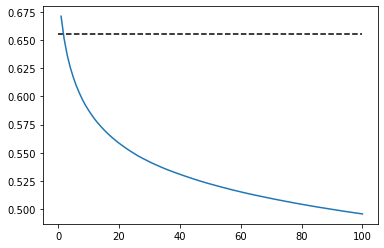

In [27]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Cossine Distance

In [28]:
emb_norm = embeddings / np.linalg.norm(embeddings, axis=1)[:, None]

In [29]:
index_cos = faiss.IndexFlatIP(emb_norm.shape[1])

In [30]:
index_cos.train(emb_norm)
index_cos.add(emb_norm)

In [31]:
index_cos

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7f2ab11302a0> >

In [32]:
index_cos.ntotal

169343

### Check if the closest embedding is a neighbor

In [33]:
distances, indices = index_cos.search(emb_norm, 2)

In [34]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(56063)

In [35]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [36]:
(sum(emb_norm[0] * emb_norm[411]) + 1) / 2

0.8450257538579535

In [37]:
max_k = 100
distances, indices = index_cos.search(emb_norm, max_k + 1)

In [38]:
indices

array([[     0,  30038, 134013, ..., 163182,  89966, 136111],
       [     1, 154949,  80996, ..., 160203,   5233, 112537],
       [     2, 113232,  65576, ...,  47319, 113955, 155006],
       ...,
       [169340,  18094,  46791, ..., 114319, 136886, 154761],
       [169341, 159963,  57079, ...,  30763,  64167, 102942],
       [169342,  68071, 156784, ..., 127868, 119601,   2889]])

In [39]:
sum(emb_norm[0] * emb_norm[411])

0.6900515077159071

In [40]:
distances

array([[0.9999999 , 0.98361737, 0.97480506, ..., 0.8632426 , 0.8632139 ,
        0.8631886 ],
       [1.0000001 , 0.98692125, 0.7257449 , ..., 0.5981141 , 0.5976397 ,
        0.5967668 ],
       [0.99999994, 0.98061347, 0.980391  , ..., 0.8889149 , 0.88832116,
        0.8868868 ],
       ...,
       [1.0000001 , 0.95374465, 0.93548036, ..., 0.8120454 , 0.81199265,
        0.8108471 ],
       [1.0000001 , 0.9684038 , 0.9664058 , ..., 0.92481476, 0.924492  ,
        0.92439073],
       [0.99999994, 0.8923167 , 0.87774354, ..., 0.66265213, 0.66256416,
        0.6601664 ]], dtype=float32)

In [41]:
has_neighbor = torch.zeros((emb_norm.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [42]:
has_neighbor

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

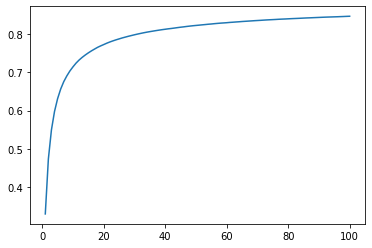

In [43]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [44]:
percentages

tensor([0.3311, 0.4740, 0.5498, 0.5977, 0.6310, 0.6559, 0.6752, 0.6902, 0.7031,
        0.7138, 0.7235, 0.7317, 0.7385, 0.7447, 0.7503, 0.7554, 0.7600, 0.7646,
        0.7684, 0.7719, 0.7754, 0.7786, 0.7815, 0.7842, 0.7866, 0.7891, 0.7912,
        0.7934, 0.7953, 0.7973, 0.7991, 0.8009, 0.8026, 0.8041, 0.8055, 0.8069,
        0.8082, 0.8094, 0.8106, 0.8117, 0.8128, 0.8138, 0.8148, 0.8160, 0.8170,
        0.8180, 0.8190, 0.8200, 0.8208, 0.8216, 0.8224, 0.8232, 0.8239, 0.8248,
        0.8254, 0.8262, 0.8270, 0.8276, 0.8282, 0.8287, 0.8295, 0.8300, 0.8307,
        0.8312, 0.8319, 0.8324, 0.8329, 0.8334, 0.8340, 0.8345, 0.8349, 0.8355,
        0.8360, 0.8364, 0.8368, 0.8372, 0.8377, 0.8381, 0.8384, 0.8389, 0.8393,
        0.8396, 0.8400, 0.8403, 0.8408, 0.8412, 0.8415, 0.8418, 0.8421, 0.8425,
        0.8429, 0.8432, 0.8435, 0.8437, 0.8440, 0.8443, 0.8446, 0.8449, 0.8453,
        0.8456])

### Percentage of same class neighbors by neighborhood size

In [45]:
ind_labels = label_transform(indices)

In [46]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [47]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [48]:
perc_same_class = n_same_class / n_total

In [49]:
perc_same_class

array([0.6828685 , 0.66516478, 0.65189389, 0.64117944, 0.63246901,
       0.62524974, 0.61878892, 0.61345612, 0.60868048, 0.60442652,
       0.60058042, 0.59719819, 0.59391476, 0.59093041, 0.58814674,
       0.5855586 , 0.58321312, 0.58093796, 0.57887651, 0.57691018,
       0.57506785, 0.57329449, 0.57156186, 0.56993892, 0.56844322,
       0.56694061, 0.56550249, 0.56411986, 0.56276885, 0.56153035,
       0.56026183, 0.55906282, 0.55794417, 0.55684165, 0.55577547,
       0.55473752, 0.55375776, 0.55279972, 0.55185114, 0.55095959,
       0.55008071, 0.54922694, 0.54839641, 0.54760215, 0.54677745,
       0.54603058, 0.54524652, 0.54452957, 0.54382682, 0.54310093,
       0.54241091, 0.54174039, 0.54106163, 0.54037444, 0.53974564,
       0.53909046, 0.53846077, 0.53788231, 0.53727211, 0.5366919 ,
       0.53611619, 0.53554182, 0.53497274, 0.53441194, 0.53387394,
       0.53334876, 0.53282136, 0.53231077, 0.53181593, 0.53131767,
       0.53081108, 0.53031799, 0.52983274, 0.52936643, 0.52888

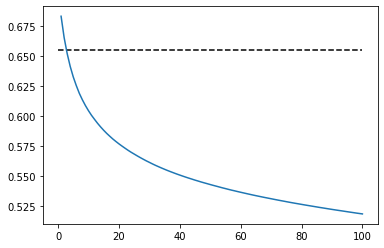

In [50]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Inner Product

In [51]:
index_ip = faiss.IndexFlatIP(embeddings.shape[1])

In [52]:
index_ip.train(embeddings)
index_ip.add(embeddings)

In [53]:
index_ip

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7f2ab1081a20> >

In [54]:
index_ip.ntotal

169343

### Check if the closest embedding is a neighbor

In [55]:
distances, indices = index_ip.search(embeddings, 2)

In [56]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(51552)

In [57]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [58]:
(sum(embeddings[0] * embeddings[411]) + 1) / 2

4.2824535847321386

In [59]:
max_k = 100
distances, indices = index_ip.search(embeddings, max_k + 1)

In [60]:
indices

array([[  1353,  67166,  25208, ...,  90495,  92115,  74060],
       [154949, 143930,      1, ...,   4126,  83256, 135984],
       [ 87117, 168209,  65187, ..., 127976,  33285, 152567],
       ...,
       [161984,  54845, 166449, ..., 160765,  80054,  97684],
       [ 61100, 123288, 140574, ..., 135300,   8091,  35575],
       [ 27824, 158981,  36111, ..., 169342,  71389,  18741]])

In [61]:
sum(embeddings[0] * embeddings[411])

7.564907169464277

In [62]:
distances

array([[30.174936 , 29.505339 , 28.012272 , ..., 18.010418 , 17.985233 ,
        17.88038  ],
       [ 3.735478 ,  3.6658916,  3.6540165, ...,  2.7676435,  2.7617247,
         2.759376 ],
       [ 8.289834 ,  8.28014  ,  8.248081 , ...,  7.06404  ,  7.0580044,
         7.0459523],
       ...,
       [ 9.526798 ,  9.2587   ,  9.050889 , ...,  7.236386 ,  7.233099 ,
         7.2244487],
       [11.432679 , 11.196553 , 10.920004 , ...,  8.288476 ,  8.286642 ,
         8.273239 ],
       [ 6.498721 ,  5.6491337,  5.0593514, ...,  3.4166555,  3.416315 ,
         3.4096317]], dtype=float32)

In [63]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [64]:
has_neighbor

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

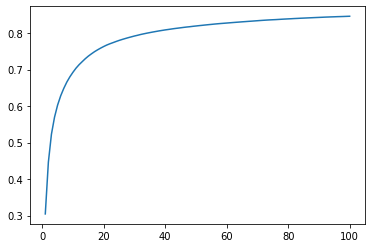

In [65]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [66]:
percentages

tensor([0.3044, 0.4460, 0.5229, 0.5693, 0.6026, 0.6279, 0.6482, 0.6657, 0.6801,
        0.6926, 0.7039, 0.7134, 0.7216, 0.7296, 0.7368, 0.7430, 0.7489, 0.7540,
        0.7588, 0.7631, 0.7672, 0.7706, 0.7737, 0.7768, 0.7798, 0.7824, 0.7850,
        0.7874, 0.7896, 0.7919, 0.7939, 0.7960, 0.7979, 0.7996, 0.8013, 0.8029,
        0.8044, 0.8059, 0.8073, 0.8086, 0.8098, 0.8111, 0.8123, 0.8133, 0.8144,
        0.8155, 0.8165, 0.8174, 0.8184, 0.8194, 0.8203, 0.8212, 0.8221, 0.8229,
        0.8237, 0.8246, 0.8254, 0.8261, 0.8268, 0.8274, 0.8281, 0.8288, 0.8295,
        0.8301, 0.8308, 0.8313, 0.8320, 0.8325, 0.8332, 0.8338, 0.8344, 0.8350,
        0.8356, 0.8361, 0.8365, 0.8369, 0.8374, 0.8379, 0.8384, 0.8388, 0.8393,
        0.8398, 0.8401, 0.8406, 0.8410, 0.8414, 0.8418, 0.8421, 0.8425, 0.8429,
        0.8432, 0.8437, 0.8440, 0.8443, 0.8446, 0.8449, 0.8451, 0.8454, 0.8458,
        0.8461])

### Percentage of same class neighbors by neighborhood size

In [67]:
ind_labels = label_transform(indices)

In [68]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [69]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [70]:
perc_same_class = n_same_class / n_total

In [71]:
perc_same_class

array([0.65315956, 0.6431562 , 0.63716835, 0.63147871, 0.62597568,
       0.62103344, 0.61639563, 0.61210088, 0.6083839 , 0.60489303,
       0.60167718, 0.59879702, 0.59597203, 0.59337389, 0.59089619,
       0.5883846 , 0.58604899, 0.58385479, 0.58172995, 0.57963276,
       0.57774317, 0.57588498, 0.57412394, 0.57246264, 0.57087473,
       0.56935991, 0.56794505, 0.56650429, 0.56516635, 0.56386525,
       0.56257876, 0.5613747 , 0.56017364, 0.55903646, 0.55791635,
       0.5567922 , 0.55576632, 0.55482442, 0.55382211, 0.5528708 ,
       0.55189835, 0.55099498, 0.55015121, 0.54928311, 0.5484725 ,
       0.54765592, 0.54687119, 0.54611941, 0.54538097, 0.54465493,
       0.54393224, 0.54320078, 0.54252378, 0.54186441, 0.54121098,
       0.54056739, 0.53990556, 0.53928173, 0.53867464, 0.538081  ,
       0.53749839, 0.53694211, 0.53637536, 0.53583343, 0.53528655,
       0.53475598, 0.53423825, 0.53369944, 0.53318712, 0.5326827 ,
       0.5321948 , 0.53170669, 0.53124513, 0.53079102, 0.53034

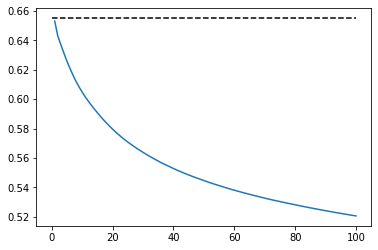

In [72]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Scatter Plot PCA 2dim

In [73]:
pca = PCA(n_components=2)

In [74]:
pca.fit(embeddings)

PCA(n_components=2)

In [75]:
emb_2d = pca.transform(embeddings)

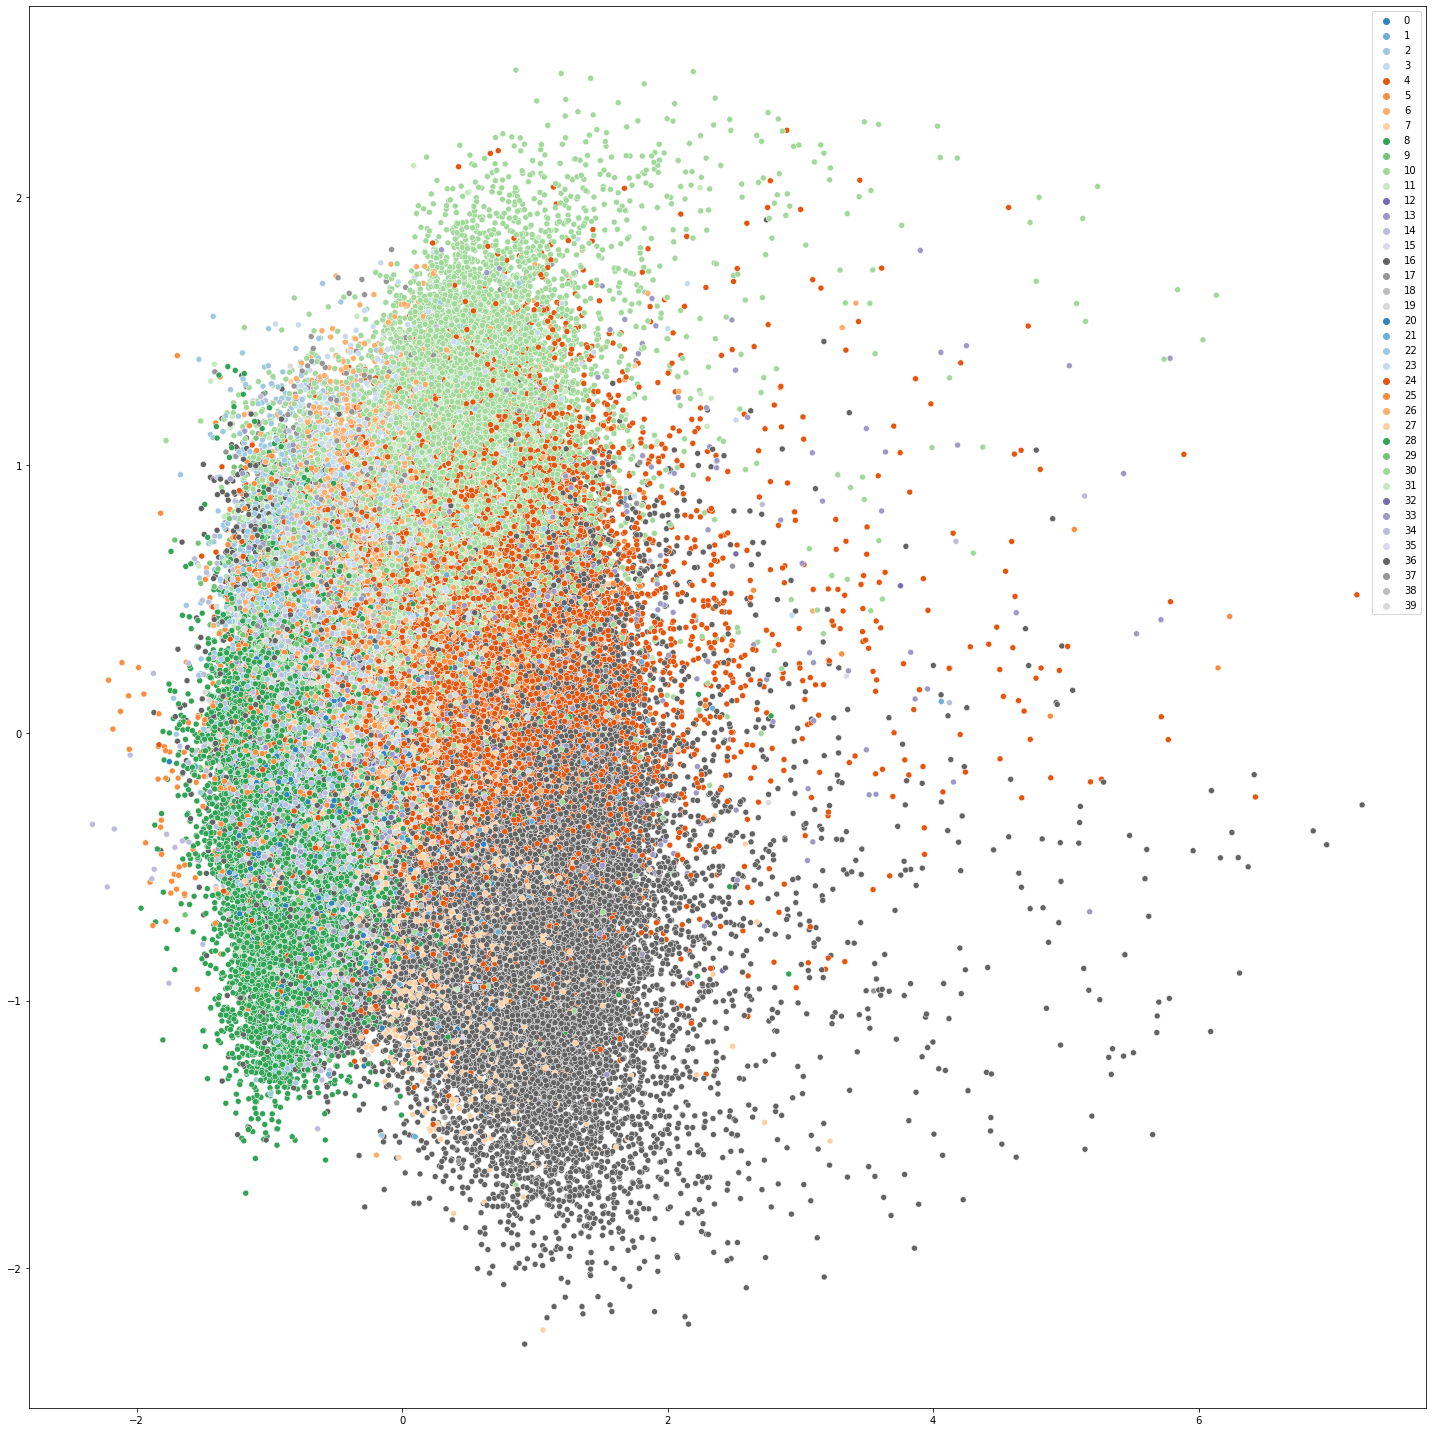

In [76]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d

In [77]:
emb_umap_2d = umap.UMAP(n_components=2).fit_transform(embeddings)

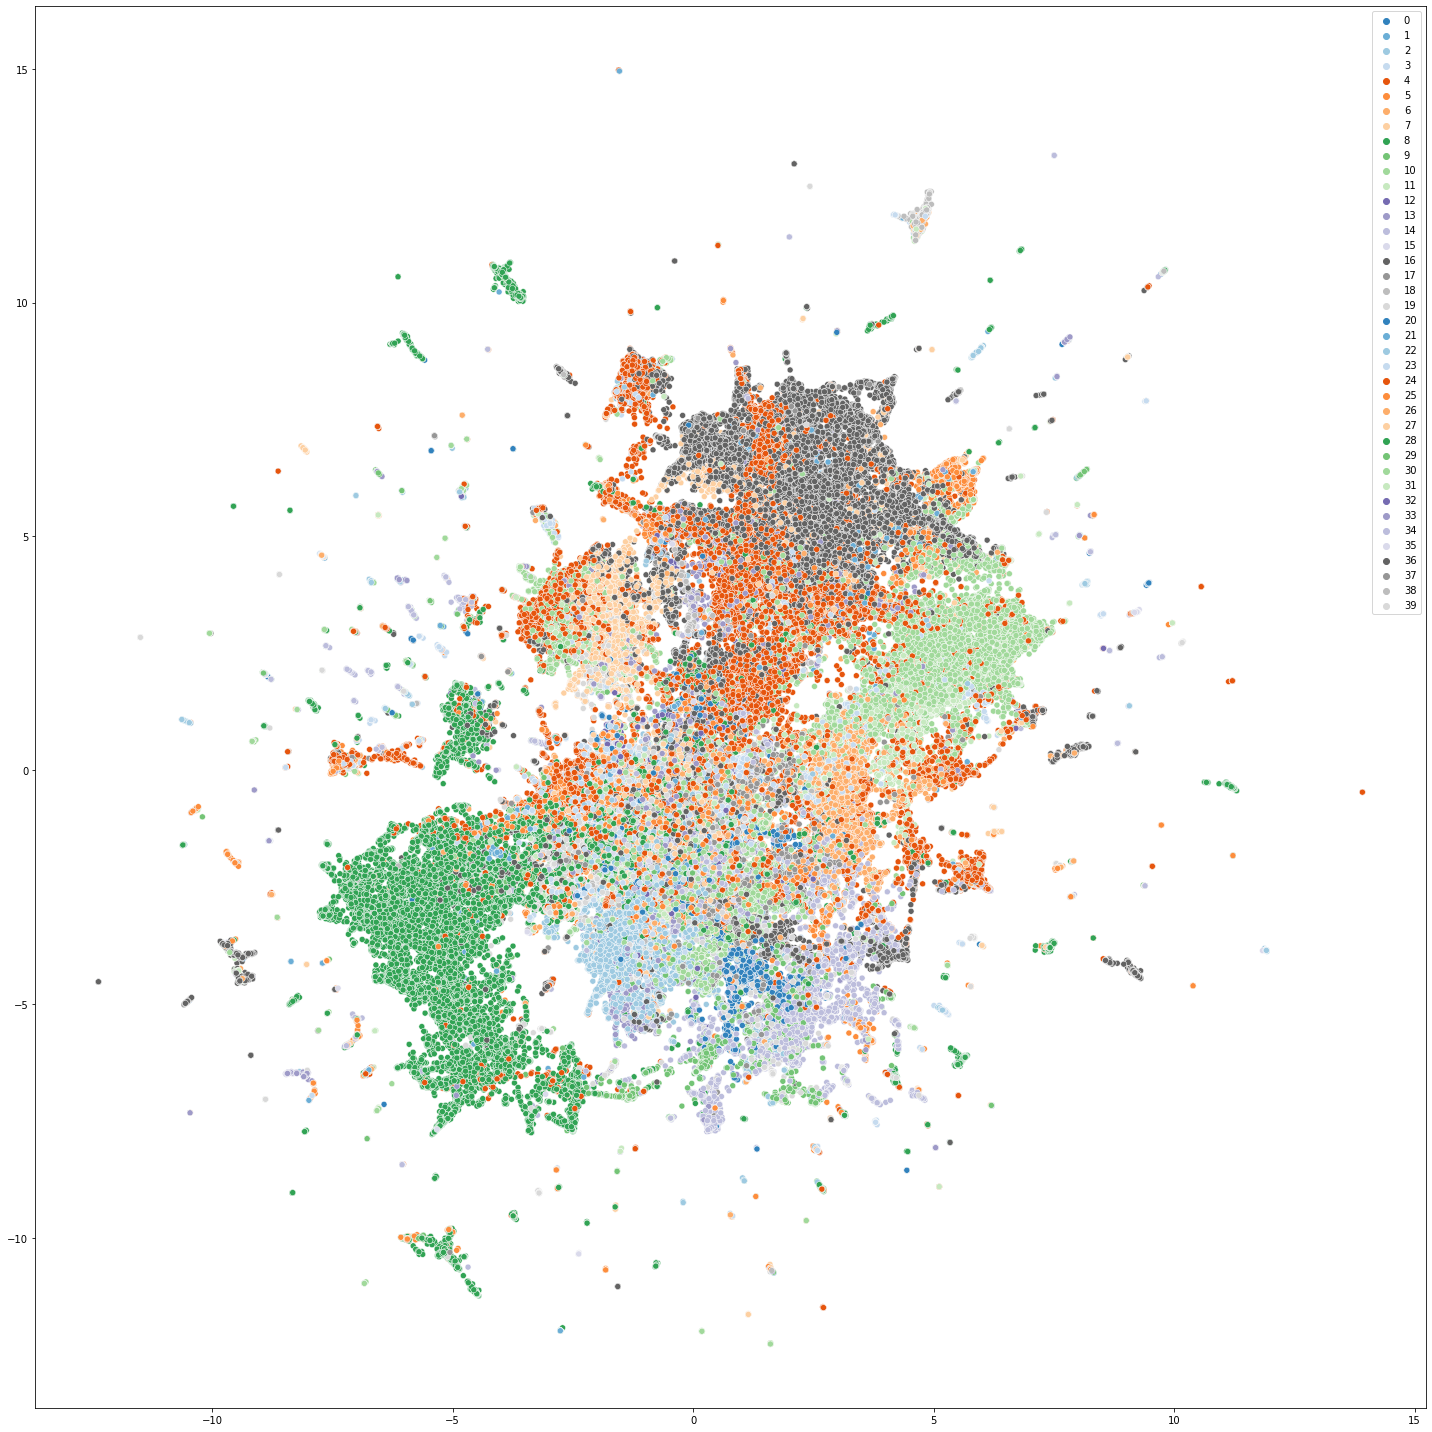

In [78]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d[:,0], y=emb_umap_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d - Normalized embeddings

In [79]:
emb_umap_2d_norm = umap.UMAP(n_components=2).fit_transform(emb_norm)

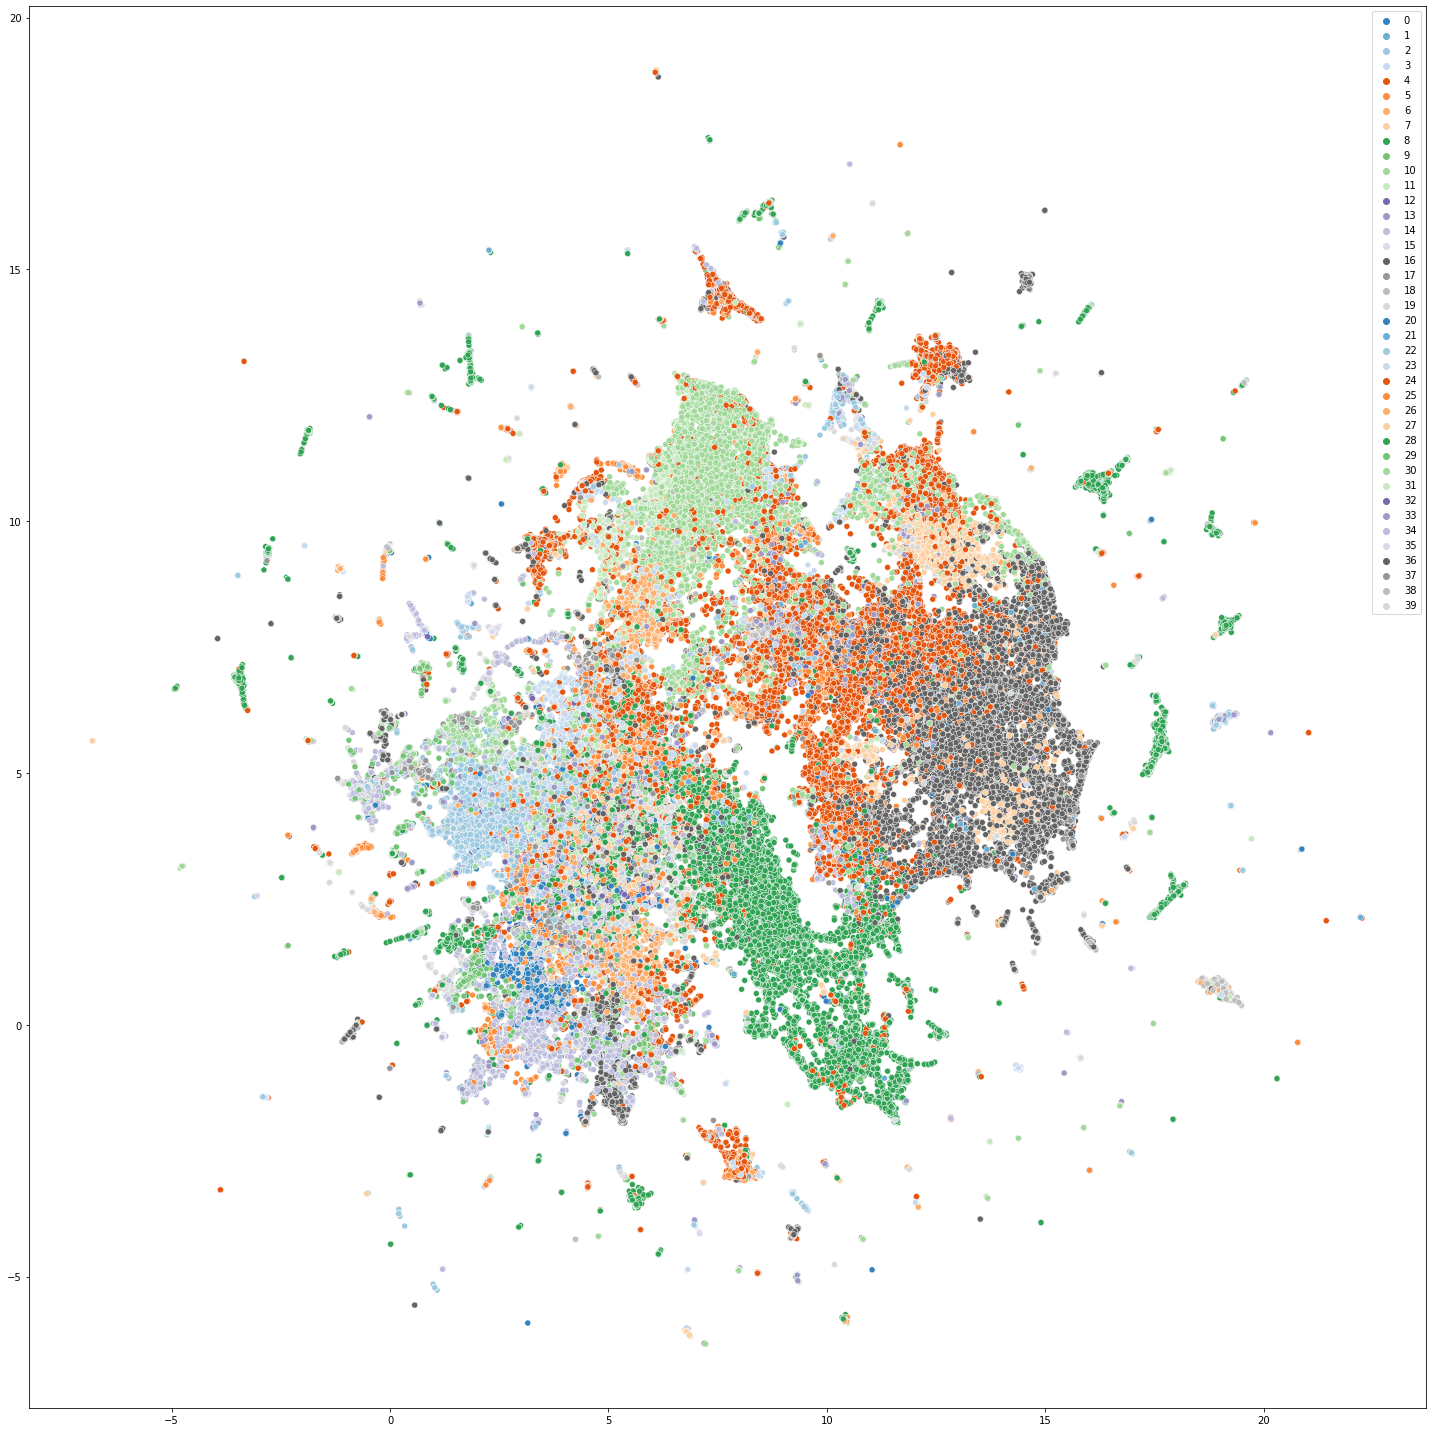

In [80]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d_norm[:,0], y=emb_umap_2d_norm[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()